# Setup

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [337]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
pd.set_option('display.max_rows', 10)
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.transforms as mtransforms
plt.rcParams['figure.figsize'] = [16, 5]
pal = plt.get_cmap('Paired').colors

import quandl

In [3]:
from utils import *

In [6]:
# api_key = open(file='quandl_api').read().replace('\n', '')
# quandl.ApiConfig.api_key = api_key
tickers, prices = get_quandl_sharadar(free=False)

In [7]:
prices

,,Open,High,Low,Close,Volume,Dividends,Closeunadj,Lastupdated
Ticker,Date,,,,,,,,
AABA,1998-12-31,30.238,31.875,29.000,29.613,37516800.00,0.0,236.900,2018-02-11
AAC1,1998-12-31,3.438,3.750,3.375,3.625,561000.00,0.0,3.625,2018-04-16
AACB,1998-12-31,16.750,16.750,16.438,16.438,1600.00,0.0,16.438,2018-02-11
AAME,1998-12-31,4.750,4.875,4.750,4.875,9700.00,0.0,4.875,2018-02-11
AAN,1998-12-31,4.409,4.444,4.409,4.427,3300.75,0.0,14.940,2018-02-11
...,...,...,...,...,...,...,...,...,...
ZTS,2018-07-09,86.900,87.710,86.620,87.490,1834672.00,0.0,87.490,2018-07-09
ZUMZ,2018-07-09,23.750,24.300,23.650,24.050,408607.00,0.0,24.050,2018-07-09
ZUO,2018-07-09,26.710,27.000,25.610,26.070,1325274.00,0.0,26.070,2018-07-09


# Finding the trend in a single price

See An introduction to smoothing time series in python, [part 1](http://www.nehalemlabs.net/prototype/blog/2013/04/05/an-introduction-to-smoothing-time-series-in-python-part-i-filtering-theory/) and [part 2](http://www.nehalemlabs.net/prototype/blog/2013/04/09/an-introduction-to-smoothing-time-series-in-python-part-ii-wiener-filter-and-smoothing-splines/).

Series to check:

* AKTC

2188 days.


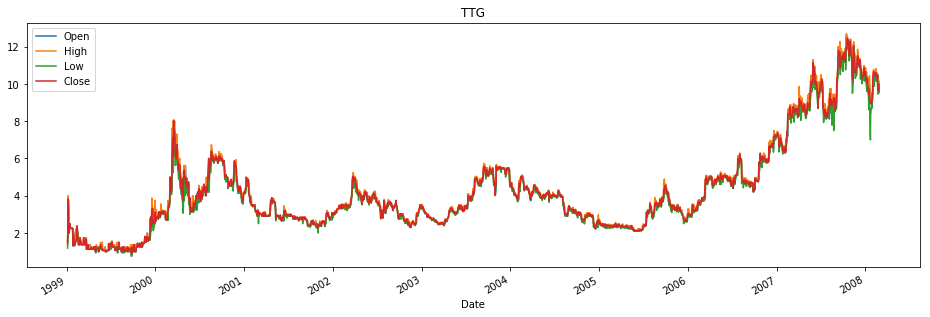

In [117]:
ticker = np.random.choice(tickers)
price = prices.loc[ticker]
print(len(price), 'days.')
price[['Open', 'High', 'Low', 'Close']].plot()
plt.title(ticker);

## Filters

In [118]:
from scipy.interpolate import UnivariateSpline
from scipy.signal import wiener, filtfilt, butter, gaussian, freqz
from scipy.ndimage import filters
import scipy.optimize as op

### Linear 

In [119]:
N = 61
f_sma = np.ones(N) / N

### Gaussian

In [168]:
N_ga = 151
f_ga = gaussian(N_ga, std=20.)
f_ga = f_ga / f_ga.sum()

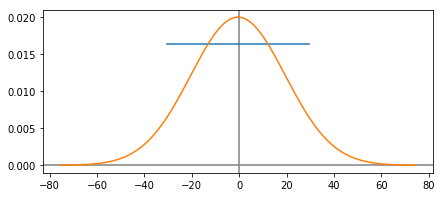

In [169]:
plt.figure(figsize=(7, 3))
plt.axhline(c='grey')
plt.axvline(c='grey')
plt.plot(np.arange(-N/2, N/2), f_sma, label='f_sma')
plt.plot(np.arange(-N_ga/2, N_ga/2), f_ga, label='f_ga')
plt.show()

### Wiener 

In [170]:
sigma = np.std(price.Close)
f_wi = lambda x: wiener(x, mysize=N, noise=sigma)

### Spline

In [171]:
f_sp = lambda x: UnivariateSpline(np.arange(len(x)), x)(np.arange(len(x)))

### Results

<Figure size 1152x432 with 0 Axes>

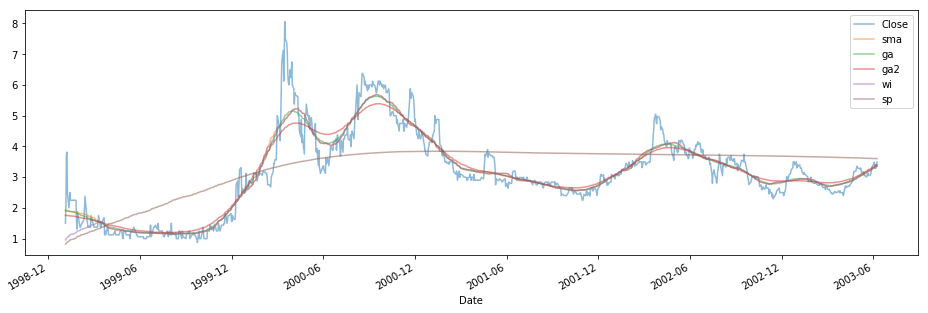

In [172]:
plt.figure(figsize=(16, 6))
results = price[['Close']].assign(sma=filters.convolve1d(price.Close, f_sma),
                                  ga=filters.convolve1d(price.Close, f_ga),
                                  ga2=filters.convolve1d(filters.convolve1d(price.Close, f_ga), f_ga),
                                  wi=f_wi(price.Close),
                                  sp=f_sp(price.Close))
results[:1000].plot(alpha=0.5);

<Figure size 1152x432 with 0 Axes>

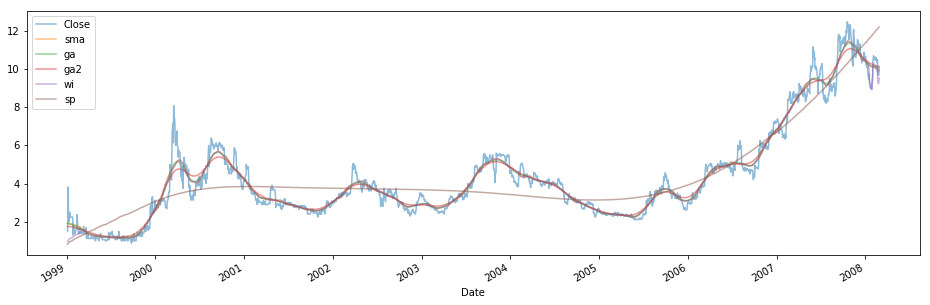

In [173]:
plt.figure(figsize=(16, 6));
results.plot(alpha = 0.5);

## Trends 

### Peaks and Valleys

In [192]:
from scipy.signal import find_peaks, find_peaks_cwt
from sklearn.metrics import confusion_matrix

In [193]:
results = results.assign(smoothed=results.ga)
# results = results[:1000]

In [270]:
results = results.assign(Trend=np.nan)
peaks, _ = find_peaks(results.smoothed)
valleys, _ = find_peaks(-results.smoothed)

In [271]:
# Begining
if valleys.min() < peaks.min():
    peaks = np.concatenate((-np.ones(1, dtype=np.int32), peaks))
else:
    valleys = np.concatenate((-np.ones(1, dtype=np.int32), valleys))

# End
if valleys.max() > peaks.max():
    peaks = np.concatenate((peaks, np.ones(1, dtype=np.int32)*len(results) - 2))
else:
    valleys = np.concatenate((valleys, np.ones(1, dtype=np.int32)*len(results) - 2))

> TO DO: Checks.

In [272]:
results['Trend'][peaks + 1] = -1
results['Trend'][valleys + 1] = 1
results.Trend.fillna(method='ffill', inplace=True)

In [273]:
results

,Close,sma,ga,ga2,wi,sp,smoothed,Trend,Trend2
Date,,,,,,,,,
1999-01-04,1.500,1.897590,1.925403,1.757250,0.960066,0.824331,1.925403,-1.0,-1.0
1999-01-05,2.125,1.891443,1.924154,1.756673,0.982607,0.842528,1.924154,-1.0,-1.0
1999-01-06,3.750,1.893492,1.921661,1.755521,1.007197,0.860652,1.921661,-1.0,-1.0
1999-01-07,3.813,1.898623,1.917941,1.753797,1.034869,0.878705,1.917941,-1.0,-1.0
1999-01-08,2.500,1.894525,1.912998,1.751507,1.053311,0.896687,1.912998,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...
2008-02-21,9.760,9.935738,10.055333,10.129584,9.357165,12.099477,10.055333,-1.0,-1.0
2008-02-22,9.670,9.922787,10.054945,10.127705,9.262990,12.121941,10.054945,-1.0,-1.0
2008-02-25,9.650,9.914098,10.054652,10.126296,9.230235,12.144428,10.054652,-1.0,-1.0


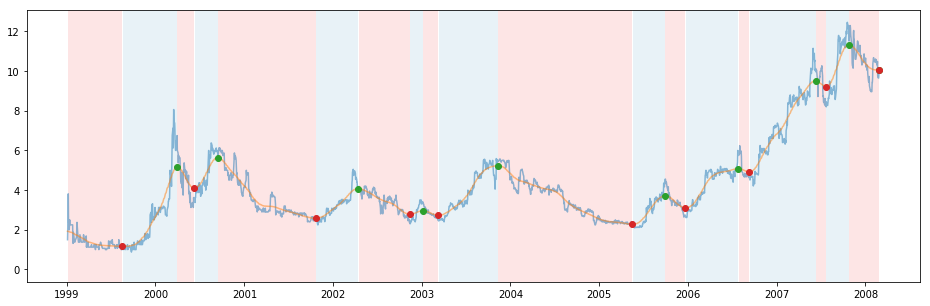

In [274]:
fig, ax = plt.subplots(figsize=(16, 5))
trans = matplotlib.transforms.blended_transform_factory(ax.transData, ax.transAxes)
ax.fill_between(results.index, 0, results.Trend.max(), where= results.Trend > 0, facecolor=pal[0],
                        alpha=0.25, transform=trans, label='Trend up')
ax.fill_between(results.index, 0, results.Trend.max(), where= results.Trend < 0, facecolor=pal[4],
                alpha=0.25, transform=trans, label='Trend down')
plt.plot(results['Close'], alpha = 0.5)
plt.plot(results['smoothed'], alpha = 0.5)
plt.plot(results.iloc[peaks]['smoothed'], 'o', label='peaks')
plt.plot(results.iloc[valleys]['smoothed'], 'o', label='valleys')
plt.show()

### Slopes

In [275]:
results = results.assign(Trend2=results.smoothed.pct_change().apply(np.sign))
results.Trend2[0] = results.Trend2[1]

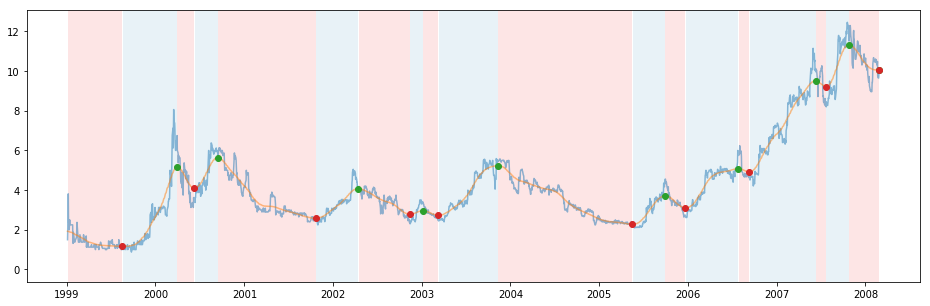

In [276]:
fig, ax = plt.subplots(figsize=(16, 5))
trans = matplotlib.transforms.blended_transform_factory(ax.transData, ax.transAxes)
ax.fill_between(results.index, 0, results.Trend2.max(), where= results.Trend2 > 0, facecolor=pal[0],
                        alpha=0.25, transform=trans, label='Trend2 up')
ax.fill_between(results.index, 0, results.Trend2.max(), where= results.Trend2 < 0, facecolor=pal[4],
                alpha=0.25, transform=trans, label='Trend2 down')
plt.plot(results['Close'], alpha = 0.5)
plt.plot(results['smoothed'], alpha = 0.5)
plt.plot(results.iloc[peaks]['smoothed'], 'o', label='peaks')
plt.plot(results.iloc[valleys]['smoothed'], 'o', label='valleys')
plt.show()

In [277]:
confusion_matrix(results.Trend.values, results.Trend2) / len(results)

array([[5.34734918e-01, 0.00000000e+00],
       [4.57038391e-04, 4.64808044e-01]])

> Both methods are equivalent!!

## Max drawdown within trend

-> For trailing stop-loss orders...

In [298]:
breakpoints = np.concatenate((-np.ones(1, dtype=np.int32), peaks, valleys))
breakpoints.sort()

In [371]:
b = 3

trend_start = breakpoints[b - 1] + 1
trend_end = breakpoints[b] + 1
res_b = results[trend_start:trend_end]
trend_b = res_b.Trend[0]

# Adjust for position (long, short)
close_b = res_b.Close[0] * res_b.Close.pct_change()[1:].mul(trend_b).add(1).cumprod()  
close_b[res_b.index[0]] = res_b.Close[0]
close_b = close_b.sort_index()

peak = close_b[0]
low = peak
drawdown = 0
max_drawdown = 0

for i in range(1, len(close_b)):
    # Max drawdown
    if close_b[i] > peak:
        peak = close_b[i]
        low = peak
    if close_b[i] < low:
        low = close_b[i]
        drawdown = low / peak - 1
    max_drawdown = min(drawdown, max_drawdown)

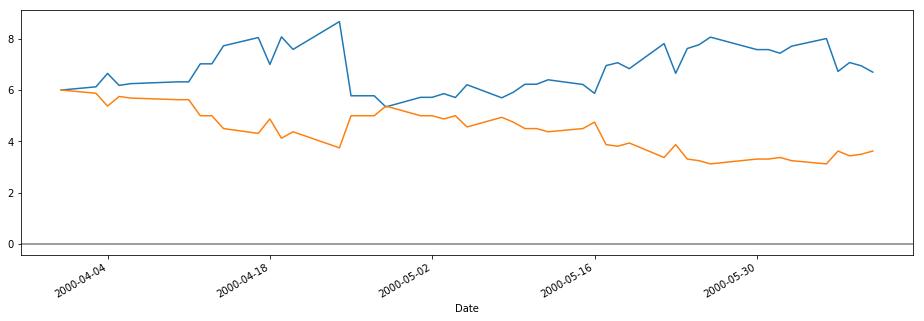

In [373]:
close_b.plot()
res_b.Close.plot()
plt.axhline(0, c='grey')